
В этом задание мы спрогнозируем норму сбережения M2-M0 байесовским методом, используя вероятностный язык программирования Stan. В задании нужно будет смоделировать сезонную компоненту.

Stan - высокопроизводительный фреймворк для байесовских моделей и не только. На нем удобно сформулировать модель в виде уравнений, и далее программа методом точечной оптимизации, MCMC, или Variational Inference оценивает параметры с высокой производительностью. От конкурентов его отличает очень хорошая реализация алгоритма HMC (Hamilton Markov Chain). Подробнее о Stan - https://mc-stan.org/users/documentation/. 

Stan manual - https://github.com/stan-dev/stan/releases/download/v2.17.1/stan-reference-2.17.1.pdf



In [10]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv(r"data_saving_rate.csv",sep=';',index_col='Date', decimal=',')
data.index = pd.to_datetime(data.index, format='%d.%m.%Y')
data = data.dropna(axis=1)
data.head()

,Savings_rate,M2-M0
Date,,
2009-12-31,13.8,11229.5
2010-01-31,1.3,11030.8
2010-02-28,9.8,11286.4
2010-03-31,7.7,11653.3
2010-04-30,10.5,11917.6


In [11]:
data['M_growth'] = data['M2-M0'][1:] - data.shift(1)['M2-M0'][1:] # прирост M2-M0 будет нашей целевой переменной
data = data.dropna(axis=0)
data.head()

,Savings_rate,M2-M0,M_growth
Date,,,
2010-01-31,1.3,11030.8,-198.7
2010-02-28,9.8,11286.4,255.6
2010-03-31,7.7,11653.3,366.9
2010-04-30,10.5,11917.6,264.3
2010-05-31,6.7,12230.3,312.7


Создадим файл с кодом на языке stan. Допишите кусок кода. '//' - комментарии в Stan

In [14]:
%%writefile model.stan

//определяем тип данных для модели

data{
    int<lower=0> N; // длина обучающей выборки
    int<lower=0> D; // количество факторов
    int<lower=0> P; // длина тестовой выборки
    real y[N]; // целевая переменная из обучающей выборки
    real x[D,N+P]; // матрица факторов
}

parameters{ //задаем параметры
    real alpha[D];//коэффициенты линейной регрессии
    real s[N]; //сезонная составляющая
    real sigma; //ошибка регрессии
    real sigma2; //ошибка сезонной составляющей
}


model{ // модель представляет собой: y = (факторы * коэф) + сезонная составляющая + ошибки
    for (i in 1:N){
        real prd;
        prd =0;
        for(j in 1:D)  prd=prd+x[j,i]*alpha[j]; #

        y[i]~normal(prd+s[i], sigma); //y = (факторы*коэф) + сезонность + ошибка
    }

    
//------------Задание!!!!!!!: дописать слагаемые, описывающие сезонность----------
//------------сумма сезонных приростов за каждый месяц в сумме должна равняться 0---------
//   s[n] ~ Normal(s[n-11]+..+s[n-1],sigma2); 
    
   for (k in 12:N){           
 //...............................................      
       real prd;
       prd = 0;
       for (l in 1:11) prd = prd - s[k-l];
       s[k]~normal(prd,sigma2);
   }
//---------------------------------------------!!!!!!!!!!!!!!!!!!!!!!!!!!!!!------------------------

}

generated quantities{
    real predY[N+P];
    real predS[N+P];
    for(k in 1:11) predS[k] = s[k];
    for (k in 12:N+P){
        real prd;
        prd =0;
        for(l in 1:11) prd=prd-predS[k-l];

        predS[k] = normal_rng(prd,sigma2);
    }

    for(i in 1:N+P){
        real prd;
        prd =0;
        for(j in 1:D)  prd=prd+x[j,i]*alpha[j];
        predY[i] = prd+predS[i];


    }
}

Overwriting model.stan


In [15]:
#скомпилируем код stan в машинный код

import pystan
model = pystan.StanModel(file='model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_962841108b6516fee7ad553e50670d64 NOW.


In [16]:
#разобьем данные на тестовую и обучающую выборку

factor = data.M_growth
y = data.Savings_rate
length = len(y)
factor_study = factor.head(int(2 / 3 * length))
factor_test = factor.tail(length-int(2 / 3 * length))

y_study = y.head(int(2 / 3 * length))
y_test = y.tail(length-int(2 / 3 * length))

In [17]:
#подготовим данные для stan


N = len(y_study)
P = len(y_test)
D = 1
y_stan = np.array(y_study)
x_stan = [np.array(factor)]
data_stan = dict(N=N, D=D, P=P, y=y_stan, x=x_stan)

In [18]:
#обучим модель и сделаем прогноз
#Мы применяем метод Markov Chain Monte Carlo для симуляций из постериорного распределения параметров.
#В данном случае мы делаем 2000 симуляций и 2 попытки.
#В модели могут всплыть предупреждения о сходимости и т.п. Так как в алгоритме MCMC много параметров управления,
#которые следует вдумчиво подобирать. Здесь мы просто знакомимся с методом. 
fitModel = model.sampling(data=data_stan, iter=200, chains=2)

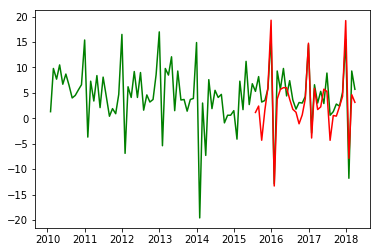

In [20]:
#Построим графики

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.plot(y, c='green')  # факт
yfittedAndForecasted = np.mean( np.array(fitModel.extract()['predY']), axis = 0) #fitted_value + прогноз
yforecasted = yfittedAndForecasted[-len(y_test):]# прогноз
plt.plot(y_test.index, yforecasted, c='red')
plt.show()

In [21]:
stanModRmse = np.sqrt(np.mean((yforecasted - y[-len(y_test):])**2))
stanModRmse

3.1594683319826249

In [23]:
naiveModelRmse = np.sqrt(np.mean(( np.mean(y_test) - y[-len(y_test):] )**2)) # модель, в которой прогноз целевой переменной равен среднему значению предыдущих.
naiveModelRmse

5.9402967773916355

In [24]:
#Проверка!

stanModRmse < naiveModelRmse


True